In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [3]:
np.random.seed(1773)

In [4]:
CSV_PATH = "/home/ubuntu/auto/dataset/train.csv"
df = pd.read_csv(CSV_PATH)

In [5]:
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
SIZE = 255
BS = 64
GPU = 3
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
print(EXP_NAME)

64-255-2020-04-04_12:40:00


In [6]:
item_tfms = [Resize(SIZE)]

In [7]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/auto/dataset/train", 
                                item_tfms=item_tfms, valid_pct=0.2,
                                bs=BS, num_workers=16, device=GPU)

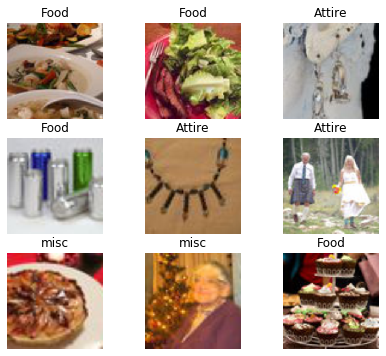

In [8]:
dls.show_batch(max_n=9, figsize=(7,6))

In [9]:
print(dls.vocab)
len(dls.vocab),dls.c

(#4) ['Attire','Decorationandsignage','Food','misc']


(4, 4)

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)
learn = Learner(dls, model, metrics=[error_rate, accuracy], opt_func=ranger, cbs= MixUp())

Loaded pretrained weights for efficientnet-b0


In [11]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.091498,1.033669,0.431438,0.568562,00:18


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.811625,1.236370,0.599498,0.400502,00:16
1,0.760508,1.229073,0.561037,0.438963,00:16
2,0.734011,0.874104,0.336957,0.663043,00:16
3,0.682697,0.953947,0.404682,0.595318,00:16
4,0.619695,0.752018,0.254181,0.745819,00:16
5,0.576697,0.597663,0.199833,0.800167,00:17
6,0.547807,0.544385,0.166388,0.833612,00:16
7,0.520834,0.489462,0.164716,0.835284,00:16
8,0.502490,0.461028,0.158027,0.841973,00:16
9,0.496213,0.462208,0.158863,0.841137,00:16


In [23]:
learn.freeze()
learn.fit_sgdr(2,5, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.509511,0.519595,0.167224,0.832776,00:17
1,0.501507,0.511268,0.165552,0.834448,00:17
2,0.490430,0.541796,0.161371,0.838629,00:17
3,0.484754,0.506590,0.158027,0.841973,00:17
4,0.484584,0.499741,0.156355,0.843646,00:17
5,0.492314,0.681699,0.196488,0.803512,00:17
6,0.508458,0.579145,0.171405,0.828595,00:17
7,0.505754,0.574051,0.181438,0.818562,00:17
8,0.485272,0.580429,0.172241,0.827759,00:17
9,0.477531,0.563266,0.164716,0.835284,00:17


In [24]:
learn.unfreeze()
learn.fit_sgdr(2,5, slice(2e-7, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.448962,0.521907,0.153846,0.846154,00:17
1,0.452146,0.517545,0.155518,0.844482,00:17
2,0.457767,0.520293,0.155518,0.844482,00:17
3,0.449290,0.520268,0.153846,0.846154,00:17
4,0.447854,0.519985,0.154682,0.845318,00:17
5,0.439095,0.526540,0.155518,0.844482,00:17
6,0.438143,0.509185,0.155518,0.844482,00:17
7,0.438861,0.520386,0.154682,0.845318,00:17
8,0.442726,0.538680,0.156355,0.843646,00:17
9,0.448499,0.506436,0.157191,0.842809,00:17


[('misc', 'Food', 33),
 ('misc', 'Attire', 28),
 ('Food', 'misc', 26),
 ('Attire', 'Food', 23),
 ('Food', 'Attire', 23),
 ('Decorationandsignage', 'Food', 13),
 ('Food', 'Decorationandsignage', 13),
 ('Attire', 'misc', 12)]

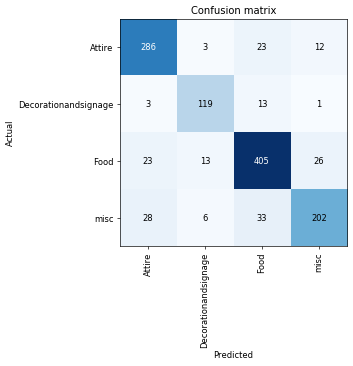

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)
interp.most_confused(min_val=10)

In [26]:
path = "/home/ubuntu/auto/dataset/test"
imgs = get_image_files(path)
test_dl = dls.test_dl(imgs)

In [27]:
preds, _ = learn.get_preds(dl=test_dl)

In [28]:
ids = [i for i in os.listdir(path)]
submission = pd.DataFrame({'Image': ids, 'Attire': preds[:,0], 'Decorationandsignage': preds[:,1], 'Food': preds[:,2], 'misc': preds[:,2]})

In [29]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [30]:
sub = submission.drop("Image", axis=1)

In [31]:
id_class = sub.idxmax(axis=1).tolist()

In [32]:
submission = pd.DataFrame({'Image': ids, 'Class': id_class})

In [33]:
submission.head()

,Image,Class
0,image3720.jpg,Decorationandsignage
1,image401.jpg,Food
2,image1058.jpg,misc
3,image5826.jpg,Decorationandsignage
4,image10659.jpg,Food


In [34]:
submission.to_csv('/home/ubuntu/auto/submission/{}.csv'.format(EXP_NAME), index=False)